In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
df= pd.read_csv('database.csv',usecols=[0,2,3,4,5,6,7,8,9,10])
#convert columns names
year_mapping = {'2000 Population':2000,'2005 Population':2005,'2010 Population':2010,'2015 Population':2015}
def convert_column_name(c):
    if c in year_mapping:
        return year_mapping[c]
    
    return c.lower().replace(' ','_')

df.columns = [convert_column_name(x) for x in df.columns]
df.head()

,name,year_established,regional_council,latitude,longitude,west_bank_barrier,2015,2010,2005,2000
0,Adora,1984,Har Hebron,31.5522,35.0189,East,404.0,240.0,206.0,271.0
1,Alei Zahav,1982,Shomron,32.0717,35.0642,West,1300.0,498.0,684.0,391.0
2,Alfei Menashe,1983,Shomron,32.1667,35.0167,West,7638.0,7079.0,5541.0,4580.0
3,Almog,1977,Megilot,31.7897,35.4611,East (Jordan Valley),207.0,170.0,159.0,167.0
4,Almon (Anatot),1982,Binyamin,31.8317,35.2954,West,1286.0,893.0,762.0,698.0


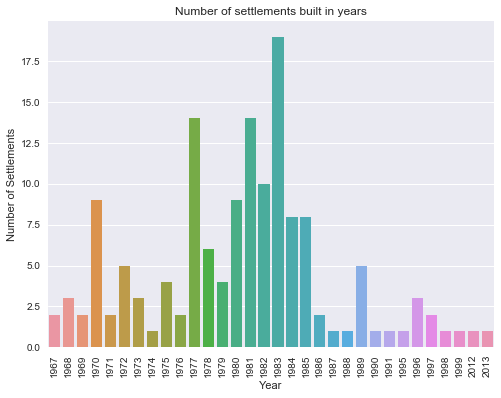

In [14]:
_ = sns.countplot(x='year_established', data=df)
plt.xticks(rotation=90)
plt.title('Number of settlements built in years')
plt.xlabel('Year')
plt.ylabel('Number of Settlements')
plt.show()

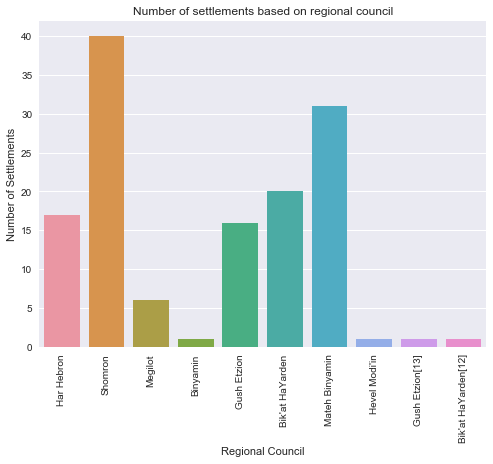

In [16]:
_ = sns.countplot(x='regional_council', data=df)
plt.xticks(rotation=90)
plt.title('Number of settlements based on regional council')
plt.xlabel('Regional Council')
plt.ylabel('Number of Settlements')
plt.show()

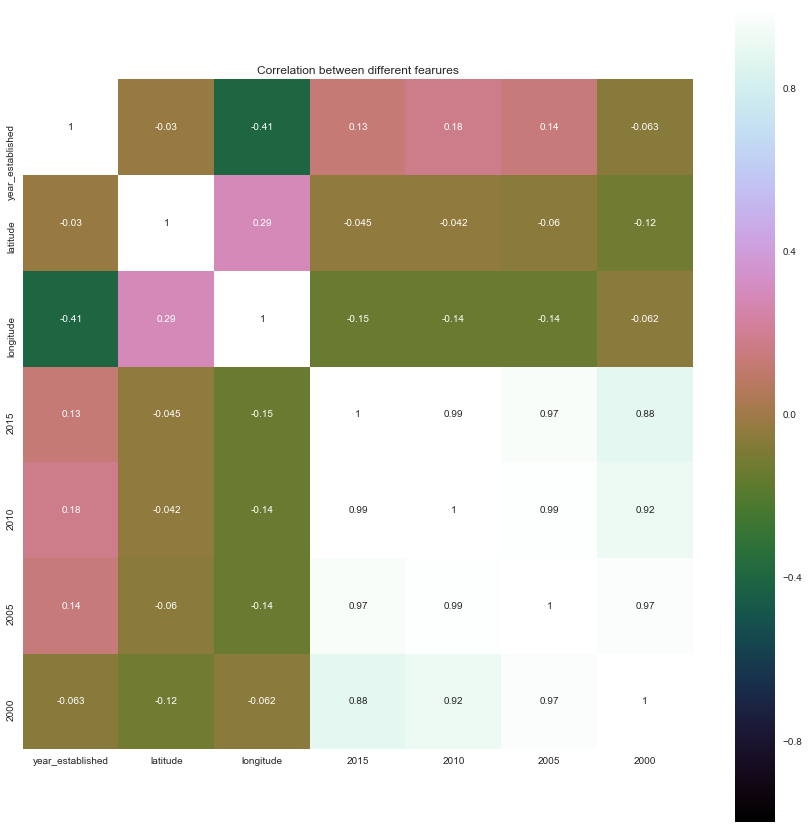

In [26]:
correlation = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')
plt.show()


the data set contains at most four data point of population size for each settlement, we will use linear regression to predict the population size for each settlement since the year it was established.
We will plot the predicted results on an animated map.

## Predicting Population Size


Assuming the population grows at an exponential rate, and we will model it using a linear regression fitted on the logarithm of the given population size.will model the population size as follows:
### log(population)=β0+β1∗isSettlement1+…+βn∗isSettlementn+βn+1∗yearsSinceEstablished

In [27]:
#unroll population per year
df_population = pd.melt(df, id_vars=['name','year_established'], value_vars=list(year_mapping.values()),
                        var_name='year',value_name='population')
df_population.dropna(inplace=True)
df_population = df_population[df_population.population>0]
df_population['years_since_established'] = (df_population.year - df_population['year_established']).astype(int)
df_population['log_population'] = df_population.population.apply(np.log)
df_population.head()

,name,year_established,year,population,years_since_established,log_population
0,Adora,1984,2005,206.0,21,5.327876
1,Alei Zahav,1982,2005,684.0,23,6.527958
2,Alfei Menashe,1983,2005,5541.0,22,8.619930
3,Almog,1977,2005,159.0,28,5.068904
4,Almon (Anatot),1982,2005,762.0,23,6.635947


In [29]:
#linear regression to estimate the log population since establishment
import statsmodels.formula.api as smf

mod = smf.ols(formula='log_population ~ name + years_since_established', data=df_population)
res = mod.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:         log_population   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     100.4
Date:                Fri, 19 May 2017   Prob (F-statistic):          3.48e-229
Time:                        00:47:55   Log-Likelihood:                 67.835
No. Observations:                 507   AIC:                             156.3
Df Residuals:                     361   BIC:                             773.7
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [34]:
END_YEAR = 2020

#predict population in every year
def predict(row):
    to_predict = []
    record = row[1]
    for year in np.arange(record['year_established'],END_YEAR+1,1):                    
        x = record.copy() 
        x['year'] = year
        x['years_since_established'] = year-x['year_established']
        to_predict.append(x)
    
    result_df = pd.DataFrame(to_predict)
    result_df['predicted_log_population'] = res.predict(result_df)
    result_df['predicted_population'] = result_df.predicted_log_population.apply(np.exp).apply(int)
    result_df = result_df.drop(['population','log_population'], 1)
    
    return result_df
              
predicted_df = []
for row in df_population.drop_duplicates('name').iterrows():
    predicted_df.append(predict(row))
    
df_predicted_population = pd.concat(predicted_df)
df_predicted_population[df_predicted_population.name=="Ma'ale Adumim"].tail()

,name,year_established,year,years_since_established,predicted_log_population,predicted_population
72,Ma'ale Adumim,1975,2016,41,10.688211,43836
72,Ma'ale Adumim,1975,2017,42,10.726475,45545
72,Ma'ale Adumim,1975,2018,43,10.764739,47322
72,Ma'ale Adumim,1975,2019,44,10.803002,49168
72,Ma'ale Adumim,1975,2020,45,10.841266,51086


In [35]:
END_YEAR = 2020

#predict population in every year
def predict(row):
    to_predict = []
    record = row[1]
    for year in np.arange(record['year_established'],END_YEAR+1,1):                    
        x = record.copy() 
        x['year'] = year
        x['years_since_established'] = year-x['year_established']
        to_predict.append(x)
    
    result_df = pd.DataFrame(to_predict)
    result_df['predicted_log_population'] = res.predict(result_df)
    result_df['predicted_population'] = result_df.predicted_log_population.apply(np.exp).apply(int)
    result_df = result_df.drop(['population','log_population'], 1)
    
    return result_df
              
predicted_df = []
for row in df_population.drop_duplicates('name').iterrows():
    predicted_df.append(predict(row))
    
df_predicted_population = pd.concat(predicted_df)
df_predicted_population[df_predicted_population.name=="Beit El"].tail()

,name,year_established,year,years_since_established,predicted_log_population,predicted_population
15,Beit El,1977,2016,39,8.869364,7110
15,Beit El,1977,2017,40,8.907628,7388
15,Beit El,1977,2018,41,8.945892,7676
15,Beit El,1977,2019,42,8.984155,7975
15,Beit El,1977,2020,43,9.022419,8286


In [36]:
END_YEAR = 2020

#predict population in every year
def predict(row):
    to_predict = []
    record = row[1]
    for year in np.arange(record['year_established'],END_YEAR+1,1):                    
        x = record.copy() 
        x['year'] = year
        x['years_since_established'] = year-x['year_established']
        to_predict.append(x)
    
    result_df = pd.DataFrame(to_predict)
    result_df['predicted_log_population'] = res.predict(result_df)
    result_df['predicted_population'] = result_df.predicted_log_population.apply(np.exp).apply(int)
    result_df = result_df.drop(['population','log_population'], 1)
    
    return result_df
              
predicted_df = []
for row in df_population.drop_duplicates('name').iterrows():
    predicted_df.append(predict(row))
    
df_predicted_population = pd.concat(predicted_df)
df_predicted_population[df_predicted_population.name=="Beitar Illit"].tail()

,name,year_established,year,years_since_established,predicted_log_population,predicted_population
19,Beitar Illit,1985,2016,31,10.628206,41283
19,Beitar Illit,1985,2017,32,10.666470,42893
19,Beitar Illit,1985,2018,33,10.704734,44566
19,Beitar Illit,1985,2019,34,10.742998,46304
19,Beitar Illit,1985,2020,35,10.781261,48110


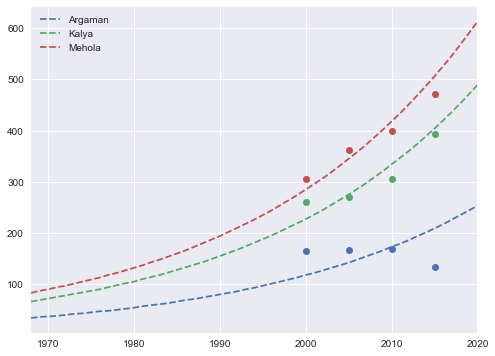

In [37]:
sns.set_style("darkgrid")


#plot predicted values
def plot_population(name):
    #plot predicted
    tmp_df = df_predicted_population[df_predicted_population.name==name]
    ax, = plt.plot(tmp_df.year,tmp_df.predicted_population,'--',label=name)
    
    #plot true values
    tmp_df = df_population[df_population.name==name]
    plt.plot(tmp_df.year,tmp_df.population,'o',color=ax.get_color(),label='')
    
    plt.legend(loc='upper left')
    
for name in df[df.year_established==1968].name:
    plot_population(name)
    
plt.xlim((1968,END_YEAR));

In [38]:
#add latitude and logitude to df
df_predicted_population_with_loc = pd.merge(df_predicted_population,
                                            df[['name','latitude','longitude']],on='name',how='left')

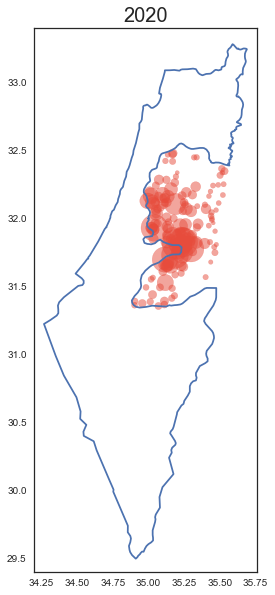

In [43]:

map_points = [[(34.998855590820305, 32.00000000000001),  (35.00000000000001, 31.997425079345657),  (35.00324249267578, 31.990127563476527),  (35.0, 31.984212875366186),  (34.989559173583984, 31.965164184570302),  (34.99199676513672, 31.942506790161048),  (35.0, 31.93330955505364),  (35.00731658935547, 31.92490005493163),  (35.03014755249023, 31.909357070922898),  (35.03498840332031, 31.893339157104464),  (35.02613830566406, 31.869981765747085),  (35.0, 31.865997314453047),  (34.97622299194336, 31.86237144470206),  (34.96389389038086, 31.846788406371985),  (34.972240447998054, 31.82001495361334),  (34.99156188964844, 31.812942504882837),  (35.0, 31.811902999877905),  (35.019195556640625, 31.809539794921925),  (35.044673919677734, 31.817346572875994),  (35.063453674316406, 31.834758758544908),  (35.08250427246094, 31.8443851470947),  (35.10449981689454, 31.826997756957994),  (35.12461853027344, 31.818763732910227),  (35.16779708862305, 31.803888320922788),  (35.214202880859375, 31.804109573364364),  (35.232418060302734, 31.787845611572358),  (35.22941207885742, 31.751674652099624),  (35.217594146728516, 31.73588180541993),  (35.167198181152344, 31.734746932983445),  (35.12457275390625, 31.71986007690432),  (35.07230758666992, 31.675645828247134),  (35.0455207824707, 31.664865493774375),  (35.02543640136718, 31.656375885009677),  (35.00883483886719, 31.64399337768551),  (34.99999999999999, 31.635826110839833),  (34.978328704833984, 31.615791320800838),  (34.96469497680664, 31.596309661865227),  (34.9537353515625, 31.583011627197283),  (34.9449462890625, 31.54544067382812),  (34.949275970458984, 31.504684448242198),  (34.94555664062499, 31.487272262573285),  (34.92554473876953, 31.454717636108427),  (34.90339660644531, 31.430171966552713),  (34.88394546508789, 31.396694183349595),  (34.886653900146484, 31.37677192687986),  (34.89789962768555, 31.361217498779368),  (34.91394042968751, 31.34979248046875),  (34.93878555297851, 31.34410858154293),  (34.98418045043945, 31.34921264648442),  (35.0, 31.352600097656275),  (35.02610778808594, 31.358192443847663),  (35.06697082519531, 31.355247497558526),  (35.12466049194336, 31.352067947387734),  (35.14576721191406, 31.361463546752944),  (35.15965270996094, 31.358715057372955),  (35.18129348754883, 31.361921310424837),  (35.199989318847656, 31.36329078674316),  (35.224037170410156, 31.367177963256797),  (35.23873901367188, 31.374729156494173),  (35.26790237426758, 31.400365829467777),  (35.29280471801757, 31.42439460754401),  (35.325172424316406, 31.43672943115231),  (35.35837173461914, 31.45753097534189),  (35.393741607666016, 31.48427391052246),  (35.409534454345696, 31.48905754089359),  (35.47558593750001, 31.48824119567879),  (35.47505569458008, 31.419759750366296),  (35.47150802612305, 31.3996105194092),  (35.45506286621094, 31.359333038329996),  (35.41720962524414, 31.300991058349585),  (35.40566635131836, 31.280853271484403),  (35.39493942260742, 31.264606475830067),  (35.389808654785156, 31.24445533752441),  (35.40121841430664, 31.223129272460938),  (35.44584655761718, 31.171499252319332),  (35.453792572021484, 31.15682029724118),  (35.458782196044915, 31.135959625244073),  (35.45978927612305, 31.1203765869141),  (35.453033447265625, 31.09472846984866),  (35.446842193603516, 31.07641029357903),  (35.4208869934082, 31.04140281677248),  (35.40858840942383, 31.02561187744146),  (35.4045295715332, 31.005224227905362),  (35.406875610351555, 30.988950729370153),  (35.415061950683594, 30.969457626342763),  (35.41499710083008, 30.948833465576172),  (35.39765930175781, 30.93511199951174),  (35.3600959777832, 30.913856506347706),  (35.3333740234375, 30.863014221191484),  (35.33306121826172, 30.84490776062014),  (35.338069915771484, 30.828399658203086),  (35.33297348022461, 30.80823516845702),  (35.31382751464844, 30.802299499511793),  (35.2989158630371, 30.78672790527342),  (35.29010772705078, 30.765878677368093),  (35.29002380371094, 30.72507858276369),  (35.27589797973633, 30.69666671752928),  (35.25141525268554, 30.657943725585845),  (35.24607467651367, 30.635709762573317),  (35.231201171875, 30.623798370361335),  (35.20170211791993, 30.574522018432546),  (35.19929504394531, 30.55801582336427),  (35.17667770385743, 30.467229843139624),  (35.16977310180665, 30.449346542358416),  (35.15599060058593, 30.432151794433608),  (35.15201187133789, 30.418622970581023),  (35.163379669189446, 30.40073776245116),  (35.18663024902343, 30.362215042114194),  (35.191902160644524, 30.34662246704103),  (35.188716888427734, 30.334699630737283),  (35.16647720336915, 30.313375473022383),  (35.160118103027344, 30.296178817749063),  (35.16353988647461, 30.276227951049815),  (35.14447784423828, 30.239534378051783),  (35.175811767578125, 30.119136810302713),  (35.09844589233399, 30.022563934326172),  (35.0919189453125, 29.999999999999964),  (35.07761001586914, 29.95053100585933),  (35.08076858520508, 29.872314453125053),  (35.051280975341804, 29.820911407470767),  (35.04681396484375, 29.802097320556598),  (35.049713134765625, 29.787187576293878),  (35.046821594238274, 29.766998291015618),  (35.029747009277344, 29.705041885375945),  (35.029762268066406, 29.671318054199165),  (35.032398223876946, 29.650213241577145),  (35.032669067382805, 29.6307125091553),  (35.019535064697266, 29.616704940795877),  (35.00167846679688, 29.60521507263188),  (35.0, 29.60351753234862),  (34.98645782470703, 29.589824676513675),  (34.975704193115234, 29.570997238159187),  (34.96632385253906, 29.547601699829112),  (34.95584869384765, 29.54901504516603),  (34.94356918334961, 29.535886764526456),  (34.94175338745118, 29.530830383300707),  (34.92712020874024, 29.516544342040948),  (34.92530822753906, 29.511487960815405),  (34.91800308227538, 29.50273704528802),  (34.911216735839844, 29.49664497375485),  (34.88545227050781, 29.52266502380371),  (34.872283935546875, 29.544435501098615),  (34.86752700805664, 29.561174392700163),  (34.863529205322266, 29.59030342102052),  (34.87293624877929, 29.61762428283696),  (34.87761306762695, 29.644935607910185),  (34.873111724853516, 29.663740158081016),  (34.85518264770508, 29.69100189208977),  (34.855873107910156, 29.73917961120612),  (34.753589630126946, 29.989412307739315),  (34.75503158569336, 29.999999999999964),  (34.755653381347656, 30.004556655883725),  (34.72322463989257, 30.082439422607425),  (34.637123107910156, 30.29404830932611),  (34.61674118041992, 30.36046791076654),  (34.546958923339844, 30.400077819824244),  (34.544422149658196, 30.43079185485837),  (34.565093994140625, 30.481323242187468),  (34.521690368652344, 30.525381088256786),  (34.52458572387695, 30.579957962036204),  (34.49564743041992, 30.684129714965835),  (34.407588958740234, 30.843908309936484),  (34.35051727294922, 30.987976074218746),  (34.268009185791016, 31.22360610961913),  (34.31301498413087, 31.25259780883785),  (34.357521057128906, 31.285615921020522),  (34.368568420410156, 31.30300521850595),  (34.36832809448242, 31.32993698120117),  (34.36582565307617, 31.358774185180668),  (34.37456893920898, 31.38384056091301),  (34.407901763916016, 31.4206085205078),  (34.45247650146484, 31.457437515258796),  (34.508235931396484, 31.503932952880895),  (34.53738784790039, 31.509868621826232),  (34.54627227783203, 31.523382186889684),  (34.5461311340332, 31.542613983154297),  (34.532524108886705, 31.559844970703097),  (34.489463806152344, 31.594066619873093),  (34.49972915649414, 31.607353210449265),  (34.55429077148437, 31.677579879760795),  (34.57070541381836, 31.701047897338835),  (34.57871627807617, 31.70453071594236),  (34.577735900878906, 31.711059570312518),  (34.57758331298828, 31.71208572387703),  (34.590042114257805, 31.7291107177734),  (34.640228271484375, 31.815710067749016),  (34.64800262451172, 31.830299377441474),  (34.69375228881835, 31.922323226928633),  (34.70440673828125, 31.93497467041019),  (34.70681762695313, 31.9356727600098),  (34.70625305175781, 31.939794540405277),  (34.72503662109375, 31.982484817504805),  (34.7307243347168, 32.00000000000001),  (34.73309326171876, 32.004558563232386),  (34.73419189453125, 32.019958496093764),  (34.74451828002929, 32.04944992065428),  (34.74897766113281, 32.056949615478516),  (34.75548934936524, 32.06108093261713),  (34.759002685546875, 32.066020965576215),  (34.769859313964844, 32.09484481811527),  (34.77038574218751, 32.09623718261724),  (34.78449249267578, 32.12059020996091),  (34.78816604614258, 32.14387893676757),  (34.79983139038086, 32.17960357666017),  (34.801429748535156, 32.20144271850588),  (34.806209564208984, 32.21353912353522),  (34.80760955810547, 32.215236663818324),  (34.820430755615234, 32.23078155517575),  (34.82257843017579, 32.236362457275455),  (34.83061599731445, 32.27516937255865),  (34.843528747558594, 32.30818557739251),  (34.846675872802734, 32.3349227905274),  (34.84770202636718, 32.34364700317381),  (34.8607292175293, 32.3693313598633),  (34.86852264404297, 32.3918495178222),  (34.88310623168945, 32.4464797973632),  (34.886417388916016, 32.455787658691335),  (34.89236068725586, 32.47248840332035),  (34.89585494995117, 32.500362396240234),  (34.91240310668946, 32.5543746948242),  (34.9176025390625, 32.578647613525376),  (34.92914962768554, 32.63247680664059),  (34.93632125854492, 32.657493591308565),  (34.936485290527344, 32.698558807373075),  (34.93931198120117, 32.70230484008786),  (34.94768524169922, 32.713394165038984),  (34.95354461669922, 32.72666931152337),  (34.95812606811524, 32.7775192260742),  (34.963382720947266, 32.808898925781335),  (34.96281814575195, 32.8205795288085),  (34.96426773071288, 32.82466888427733),  (34.96520233154297, 32.8273124694824),  (34.97179794311523, 32.83120727539053),  (34.98124694824219, 32.832214355468686),  (34.98563003540039, 32.836952209472656),  (34.99266052246094, 32.83741760253904),  (35.00000000000001, 32.83182525634758),  (35.0090217590332, 32.824432373046875),  (35.01562499999999, 32.81685638427741),  (35.02008819580078, 32.81425094604491),  (35.02635955810547, 32.81354522705073),  (35.03412628173828, 32.81563949584952),  (35.05250930786133, 32.82840728759763),  (35.060585021972656, 32.835556030273516),  (35.07079315185547, 32.8492012023926),  (35.073184967041016, 32.85395050048825),  (35.08196258544922, 32.87136077880862),  (35.08755111694336, 32.89104461669921),  (35.09027099609375, 32.90834045410158),  (35.08626937866211, 32.9183044433594),  (35.07870864868164, 32.91736602783201),  (35.0756721496582, 32.91841125488286),  (35.07475280761718, 32.92067718505853),  (35.08096694946288, 32.96171569824216),  (35.08271408081055, 32.967414855956974),  (35.10194778442383, 33.03008651733402),  (35.11440658569335, 33.07775497436524),  (35.11545944213867, 33.090179443359375),  (35.149497985839844, 33.09042739868161),  (35.17575454711914, 33.09230804443361),  (35.1810073852539, 33.09268188476563),  (35.21642303466796, 33.08750152587889),  (35.219905853271484, 33.088768005371115),  (35.22564697265625, 33.09401321411129),  (35.237213134765625, 33.09716415405272),  (35.274234771728516, 33.098209381103466),  (35.31272888183594, 33.102733612060625),  (35.32072067260742, 33.10115432739254),  (35.332542419433594, 33.098819732665916),  (35.34935760498046, 33.071868896484325),  (35.358776092529304, 33.062786102295),  (35.37384414672852, 33.05526733398445),  (35.37963104248047, 33.05385589599614),  (35.405067443847656, 33.0634117126464),  (35.43250274658203, 33.065238952636754),  (35.4397087097168, 33.06845474243158),  (35.456783294677734, 33.08231353759769),  (35.461700439453125, 33.0879783630371),  (35.46991729736328, 33.09305953979484),  (35.47425842285156, 33.093429565429766),  (35.49186706542969, 33.08987426757817),  (35.50879287719727, 33.09523773193351),  (35.511138916015625, 33.09760665893548),  (35.5118293762207, 33.104164123535135),  (35.512470245361335, 33.11026000976556),  (35.51473617553712, 33.114459991455156),  (35.533782958984375, 33.12126159667961),  (35.53878402709961, 33.13128280639646),  (35.54080200195312, 33.15312576293945),  (35.54707336425781, 33.177402496337876),  (35.55347442626953, 33.18677902221677),  (35.55842971801758, 33.19794082641605),  (35.557613372802734, 33.210067749023466),  (35.55622100830079, 33.21532058715822),  (35.55399703979492, 33.2237129211426),  (35.554466247558594, 33.2315216064453),  (35.56301498413085, 33.247844696044844),  (35.56884002685547, 33.251926422119105),  (35.578208923339844, 33.262313842773466),  (35.58779525756836, 33.280044555664034),  (35.59016036987304, 33.2821807861328),  (35.59720230102538, 33.27735900878903),  (35.620853424072266, 33.24897766113283),  (35.62472152709961, 33.24795150756838),  (35.62841415405273, 33.250934600830114),  (35.63676071166992, 33.24431610107427),  (35.64419937133788, 33.242824554443374),  (35.651634216308594, 33.24443054199221),  (35.66475677490235, 33.250339508056626),  (35.67073822021484, 33.250984191894545),  (35.6833610534668, 33.249538421630916),  (35.68907928466797, 33.24673080444337),  (35.690010070800774, 33.244125366210916),  (35.68144989013672, 33.22746658325201),  (35.676532745361335, 33.211837768554766),  (35.67584228515625, 33.19003677368156),  (35.67729949951172, 33.179275512695256),  (35.677650451660156, 33.17667770385739),  (35.6824951171875, 33.15928649902339),  (35.68238067626953, 33.15252304077156),  (35.678680419921875, 33.14036941528319),  (35.66377639770508, 33.106895446777344),  (35.66104888916015, 33.085029602050746),  (35.660728454589844, 33.05903625488283),  (35.657833099365234, 33.06188964843756),  (35.647056579589844, 33.05915069580078),  (35.64235687255859, 33.054531097412124),  (35.63204956054688, 33.03793334960939),  (35.615638732910156, 33.02412414550783),  (35.615982055664055, 33.01943588256833),  (35.627540588378906, 33.0011100769043),  (35.62923812866211, 32.97801208496092),  (35.627532958984375, 32.95823287963874),  (35.62482070922852, 32.92675018310537),  (35.62274932861328, 32.918205261230526),  (35.61697006225587, 32.907363891601634),  (35.61665344238281, 32.902194976806655),  (35.61874771118164, 32.897903442382805),  (35.62332534790039, 32.895755767822266),  (35.63081741333008, 32.89851379394527),  (35.63502502441406, 32.89245605468749),  (35.643802642822266, 32.88447570800782),  (35.656837463378906, 32.86299133300775),  (35.66119003295899, 32.85349655151368),  (35.663917541503906, 32.83753585815437),  (35.66199493408203, 32.822463989257756),  (35.65496063232422, 32.79989624023432),  (35.65401077270508, 32.78077316284179),  (35.65314865112305, 32.763507843017564),  (35.65011215209961, 32.74599456787104),  (35.63890075683593, 32.72616195678714),  (35.61994552612305, 32.709865570068274),  (35.619625091552734, 32.70790863037102),  (35.62686920166015, 32.70355224609375),  (35.646038055419915, 32.6962471008301),  (35.64886474609375, 32.69358444213875),  (35.64941024780274, 32.68729782104493),  (35.62122344970703, 32.67691802978522),  (35.61473464965821, 32.67065048217778),  (35.6165657043457, 32.656562805175795),  (35.60526657104492, 32.652778625488224),  (35.605735778808594, 32.646663665771534),  (35.60330581665038, 32.64425659179684),  (35.594463348388665, 32.64217376708986),  (35.579998016357415, 32.63289642333979),  (35.57866668701172, 32.62262725830077),  (35.58181381225586, 32.61951828002934),  (35.58033370971679, 32.60464859008799),  (35.582630157470696, 32.60004806518548),  (35.58308410644531, 32.599834442138665),  (35.59004592895508, 32.59660720825202),  (35.59163665771485, 32.592430114746136),  (35.591995239257805, 32.59037780761722),  (35.58726119995117, 32.581058502197166),  (35.58659362792969, 32.57164382934564),  (35.596866607666016, 32.553634643554666),  (35.59587478637695, 32.55154037475589),  (35.58585357666015, 32.551681518554695),  (35.584102630615234, 32.542228698730455),  (35.579498291015625, 32.542312622070334),  (35.57366943359376, 32.54556274414057),  (35.57154846191406, 32.54457855224611),  (35.57218551635743, 32.538639068603494),  (35.57893753051757, 32.52941513061526),  (35.57673263549804, 32.52624130249019),  (35.5666389465332, 32.5244483947754),  (35.561302185058594, 32.51807403564451),  (35.56601333618164, 32.515056610107386),  (35.57246780395507, 32.515201568603615),  (35.578857421875, 32.50284576416014),  (35.58631896972656, 32.50027847290047),  (35.58824920654297, 32.497585296630845),  (35.5870246887207, 32.492477416992244),  (35.58105087280274, 32.48277664184566),  (35.574691772460945, 32.47363662719729),  (35.573833465576165, 32.46856689453125),  (35.57538986206055, 32.46403503417976),  (35.58365249633789, 32.46063232421872),  (35.585693359375, 32.457260131835966),  (35.583206176757805, 32.452369689941385),  (35.5783462524414, 32.45221328735345),  (35.57494735717773, 32.449584960937486),  (35.57742309570312, 32.43637084960933),  (35.56566619873047, 32.433246612548785),  (35.56856155395508, 32.4106521606445),  (35.56683349609375, 32.40693283081053),  (35.559349060058594, 32.40508651733395),  (35.5583381652832, 32.40345001220703),  (35.56786346435547, 32.389778137207),  (35.56120681762695, 32.39031600952151),  (35.559730529785156, 32.390434265136705),  (35.53650665283203, 32.396102905273445),  (35.50706100463867, 32.40775299072271),  (35.49448013305664, 32.41101074218752),  (35.47173690795898, 32.4118690490722),  (35.45676803588867, 32.408168792724666),  (35.44425964355469, 32.40981674194328),  (35.43753814697266, 32.4148674011231),  (35.437847137451165, 32.41991806030269),  (35.43073272705078, 32.427703857421925),  (35.43037033081055, 32.42860794067379),  (35.4249267578125, 32.442176818847635),  (35.426170349121094, 32.4621543884277),  (35.42301559448242, 32.48359298706053),  (35.40678787231445, 32.50688934326175),  (35.390613555908196, 32.51712036132813),  (35.38214111328126, 32.518898010253906),  (35.36290740966796, 32.51916503906248),  (35.36038589477539, 32.518775939941314),  (35.31400680541992, 32.511547088623125),  (35.3023681640625, 32.51160812377922),  (35.29443359375001, 32.513397216796875),  (35.278690338134766, 32.519962310791065),  (35.26333999633789, 32.529518127441314),  (35.245529174804695, 32.54517364501962),  (35.23168182373047, 32.55156707763675),  (35.22804641723633, 32.55109405517572),  (35.22199249267579, 32.5503120422363),  (35.2166862487793, 32.54806137084955),  (35.19832229614257, 32.53045654296868),  (35.194828033447266, 32.52437591552733),  (35.182857513427734, 32.514556884765724),  (35.16315841674804, 32.50239944458002),  (35.138248443603516, 32.491653442382834),  (35.10839080810546, 32.48207855224609),  (35.0980339050293, 32.47875213623044),  (35.0904312133789, 32.47389221191403),  (35.08116149902343, 32.4591178894043),  (35.076725006103516, 32.44520568847659),  (35.07206344604493, 32.41959381103513),  (35.063362121582024, 32.39910888671874),  (35.05923843383789, 32.373748779296854),  (35.055809020996094, 32.37092971801768),  (35.052234649658196, 32.367992401123026),  (35.02625656127929, 32.35810089111323),  (35.01959228515625, 32.35098266601567),  (35.009002685546875, 32.33402252197264),  (35.007877349853516, 32.3070755004883),  (35.012577056884766, 32.27845764160163),  (35.00926208496094, 32.27102661132817),  (35.000816345214844, 32.265899658203075),  (35.0, 32.26489639282227),  (34.98706817626954, 32.249004364013764),  (34.98060989379882, 32.23659896850594),  (34.96897888183594, 32.214244842529205),  (34.967273712158196, 32.20257568359366),  (34.96772384643555, 32.19096755981452),  (34.98134994506837, 32.17361450195311),  (34.986759185791016, 32.1639823913574),  (34.99433135986329, 32.1354484558106),  (34.99554443359375, 32.1226387023925),  (34.99423599243163, 32.118328094482415),  (34.99235534667969, 32.112155914306726),  (34.984233856201165, 32.099086761474624),  (34.98310470581055, 32.09110260009764),  (34.98623657226562, 32.08446502685554),  (34.99666213989258, 32.07497024536139),  (35.00000000000001, 32.069557189941484),  (35.008155822753906, 32.056335449218686),  (35.01147460937499, 32.044807434082074),  (35.00916290283203, 32.03006744384759),  (35.00112152099609, 32.01516723632821),  (35.00137710571289, 32.00844955444331),  (35.003292083740234, 32.003055572509815),  (34.99999999999999, 32.000789642333956),  (34.998855590820305, 32.00000000000001)]]
# this will run better on a local jupyter notebook
import shapefile
from IPython import display
import time

sns.set_style("white")


for year in np.arange(1967, END_YEAR+1,1):
    # plot basic map
    plt.figure(figsize=(4,10))
    for shape in map_points:
        x,y = zip(*shape)
        plt.plot(x,y)

    # plot settlements
    curr_df = df_predicted_population_with_loc[df_predicted_population_with_loc['year']==year]
    plt.scatter(curr_df.longitude,curr_df.latitude,s = curr_df['predicted_population']**0.6,alpha =0.5,color='#e74c3c')
    plt.ylim((29.4,33.4))

    plt.title(year,fontsize=20)
    plt.show()
    

    time.sleep(0.01)
    
    if year<END_YEAR:
        display.clear_output(wait=True)

 